In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from libpysal.weights import KNN

# 假设 df 是您的数据，其中包含 'longitude'（经度）、'latitude'（纬度）和目标变量 'NE' 以及一些其他的features
df = pd.read_csv("NE_glb_cities_era5_ae_rad_1102_agg.csv") #E:\NE_glb_cities_era5_ae_0832.csv")
#df['LAI'] = df['leaf_area_index_high_vegetation'] + df['leaf_area_index_low_vegetation']
df.columns

Index(['datetime', 'longitude', 'latitude', 'NE', 'emission', 'uv10m',
       'temperature_2m', 'LAI', 'volumetric_soil_water_layer_1',
       'surface_net_solar_radiation_hourly', 'COUNTRY', 'NAME_1', 'NAME_2',
       'continent', 'lat', 'lon', 'date', 'Solar_Radiation_Flux'],
      dtype='object')

In [2]:
len(df)

237621

In [3]:
df = df.dropna(subset=['longitude','latitude',
   'temperature_2m', 
    'LAI', 'volumetric_soil_water_layer_1', 'emission', 
    'surface_net_solar_radiation_hourly', 'uv10m','Solar_Radiation_Flux'
])
len(df)

234328

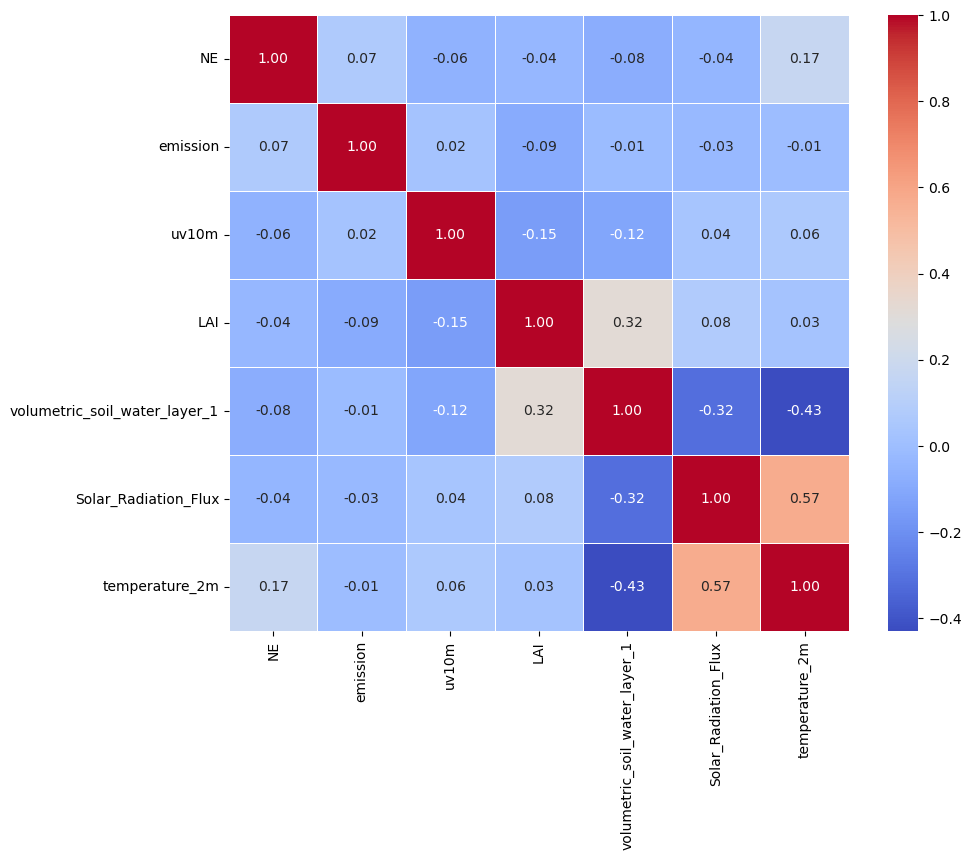

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
df1=df[['NE', 'emission', 'uv10m',
       'LAI', 'volumetric_soil_water_layer_1',
       #'surface_net_solar_radiation_hourly', 
       'Solar_Radiation_Flux', 'temperature_2m'
       ]]

# 计算相关矩阵
corr_matrix = df1.corr()

# 显示相关矩阵
plt.figure(figsize=(10, 8))
# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# Show the plot
plt.show()

In [17]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 假设df是您的数据，其中包含'longitude'（经度）、'latitude'（纬度）、'NE'（目标变量）以及一些其他的特征
# 定义特征矩阵 (X) 和目标变量 (y)
X = df[['LAI', 
       'emission',  
        'uv10m',
        'volumetric_soil_water_layer_1', 
        #'surface_net_solar_radiation_hourly',
        #'temperature_2m',
        'Solar_Radiation_Flux'
       ]]
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df['NE']


# 添加截距项 (常数项) 到特征矩阵
X = sm.add_constant(X)

# 拟合OLS模型
ols_model = sm.OLS(y, X).fit()

# 输出OLS结果的摘要
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                     NE   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     982.5
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        01:33:33   Log-Likelihood:            -5.1915e+05
No. Observations:              234328   AIC:                         1.038e+06
Df Residuals:                  234322   BIC:                         1.038e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0758      0.005    -16.536      0.0

In [57]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[['LAI', 
       'emission',  
        'uv10m',
        'volumetric_soil_water_layer_1', 
        #'surface_net_solar_radiation_hourly',
        #'temperature_2m',
        'Solar_Radiation_Flux']]  # 替换成您实际的特征名

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 输出VIF结果
print(vif_data)

                         Feature       VIF
0                            LAI  6.062512
1                       emission  1.078588
2                          uv10m  3.278983
3  volumetric_soil_water_layer_1  4.078417
4           Solar_Radiation_Flux  6.294218


In [19]:
from mgwr.sel_bw import Sel_BW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [13]:
#1s aggregation
from sklearn.preprocessing import StandardScaler
import mgwr.sel_bw as sel_bw

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# 随机抽样50%数据
gdf = gdf.sample(frac=0.23, random_state=1)
print(len(gdf))

# 提取经纬度作为坐标矩阵
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# 特征矩阵 (X) 和目标变量 (y)
# 使用 float32 来减少内存占用
X = gdf[['LAI', 
        'emission',  
        'volumetric_soil_water_layer_1', 
        'Solar_Radiation_Flux', 
        #'surface_net_solar_radiation_hourly',
        'uv10m']].values.astype(np.float32)
print('LAI', 
        'emission',  
        'volumetric_soil_water_layer_1', 
        'Solar_Radiation_Flux', 
        #'surface_net_solar_radiation_hourly',
        'uv10m')

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = gdf['NE'].values.astype(np.float32).reshape(-1, 1)

# 将数据分为训练集和测试集 (80% 训练, 20% 测试)
'''coords_train, coords_test, X_train, X_test, y_train, y_test = train_test_split(
    coords, X, y, test_size=0.2, random_state=42
)'''

# 选择训练集的带宽 (bw)
# bw = Sel_BW(coords, y, X).search()
bw = Sel_BW(coords, y, X, fixed=False, spherical=False).search(bw_min=170, bw_max=280, criterion='CV')

print("选定的带宽:", bw)

# 创建并在训练集上拟合 GWR 模型
gwr_model = GWR(coords, y, X, bw=bw, fixed=False, kernel='bisquare')
gwr_results = gwr_model.fit()

# 输出训练集结果
print("训练集 R²:", gwr_results.D2)

# 训练集的 AICc
print("训练集 AICc:", gwr_results.aicc)


53895
LAI emission volumetric_soil_water_layer_1 Solar_Radiation_Flux uv10m
选定的带宽: 252.0
训练集 R²: 0.42471403263120844
训练集 AICc: 216974.79816777218


In [14]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               53895
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         263721.008
Log-likelihood:                                                 -119262.389
AIC:                                                             238536.778
AICc:                                                            238538.780
BIC:                                                            -323388.491
R2:                                                                   0.021
Adj. R2:                                                              0.021

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

GWR模型已保存到: E:\gwr_model_1101.pkl


In [ ]:
'LAI', 
'emission', 
'volumetric_soil_water_layer_1', 
'Solar_Radiation_Flux', 
'surface_net_solar_radiation_hourly',
'uv10m'

In [157]:
gdf['LAI'].max()

10.3892822265625

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize, LinearSegmentedColormap

# 提取系数
params = gwr_results.params

# 将系数添加到 GeoDataFrame
gdf['LAI_coef'] = params[:, 1]  # LAI 的系数
gdf['emission_coef'] = params[:, 2]  # emission 的系数
#gdf['volumetric_soil_water_layer_1_coef'] = params[:, 3]  # volumetric_soil_water_layer_1 的系数
#gdf['Solar_Radiation_Flux_coef'] = params[:, 4]  # Solar_Radiation_Flux 的系数
#gdf['surface_net_solar_radiation_hourly_coef'] = params[:, 5]  # surface_net_solar_radiation_hourly 的系数
#gdf['uv10m_coef'] = params[:, 6]  # uv10m 的系数

print(gdf['LAI_coef'].min(), gdf['LAI_coef'].max())
print(gdf['emission_coef'].min(), gdf['emission_coef'].max())

-8.790589754951771 6.8602573378437315
-10.293823857925078 18.1957675283714


/var/folders/d8/sjpsqxx96jx3_z187n5nywf80000gn/T/ipykernel_82771/394000105.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


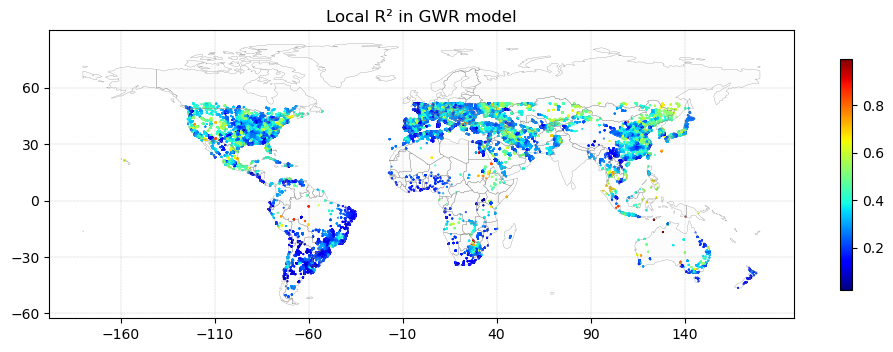

In [161]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 将 local R² 值添加到 GeoDataFrame
gdf['local_R2'] = gwr_results.localR2

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 过滤掉南极洲
world = world[world.name != 'Antarctica']  # 移除南极洲

# 创建图形
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# 绘制灰色世界地图
world.boundary.plot(ax=ax, linewidth=0.2, color='gray')  # 添加世界地图边界
world.plot(ax=ax, color='lightgray', alpha=0.05)  # 添加世界地图填充

# 绘制 local R² 地图
gdf.plot(column='local_R2', ax=ax, 
         legend=True, cmap='jet', 
         markersize=0.25, 
         #alpha=0.8,
         legend_kwds={'shrink': 0.3})

ax.set_title('Local R² in GWR model')

# 设置经纬度网格
ax.grid(True, which='both', linestyle='--', linewidth=0.2, alpha=0.8, color='gray')
ax.set_xticks(range(-160, 181, 50))  # 设置经度刻度
ax.set_yticks(range(-60, 75, 30))    # 设置纬度刻度

plt.tight_layout()
plt.show()

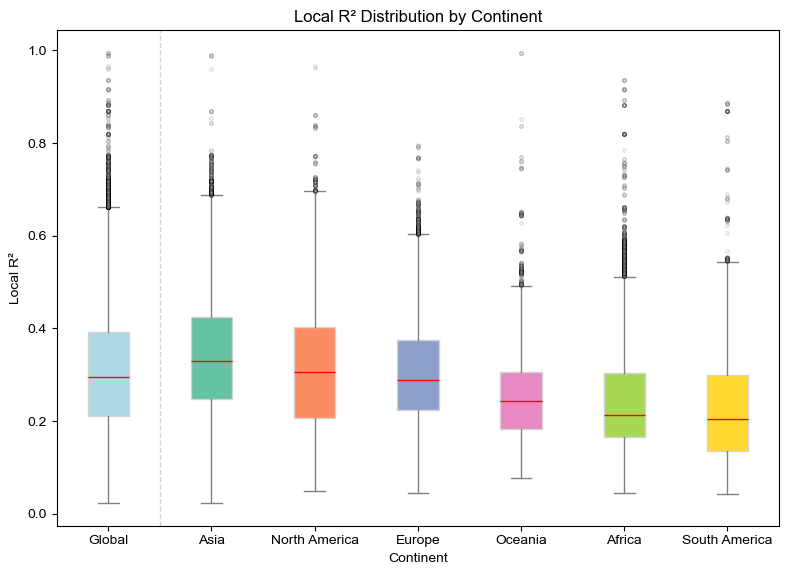

In [354]:
import matplotlib.pyplot as plt
import numpy as np

# 设置默认字体为 Arial
plt.rcParams['font.family'] = 'Arial'

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(8, 6))  # 可以调整图形大小

colors = plt.get_cmap('Set2').colors  # 适合离散分类数据的调色板

# 计算每个 continent 的中位数并进行排序
median_values = {continent: gdf[gdf['continent'] == continent]['local_R2'].median() for continent in gdf['continent'].unique()}
sorted_continents = sorted(median_values, key=median_values.get, reverse=True)

# 添加全体数据（global 数据）的箱线图
global_data = gdf['local_R2']
ax.boxplot(global_data, positions=[0], 
            widths=0.4,  # 调整宽度
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='lightgray'),
            medianprops=dict(color='red'), 
            whiskerprops=dict(color='gray'), 
            capprops=dict(color='gray'),
            flierprops=dict(marker='o', markerfacecolor='lightgray', markersize=2.5, alpha=0.1, linestyle='none'))  # 修改轮廓点的样式

# 为每个 continent 的数据绘制箱线图
for i, continent in enumerate(sorted_continents):
    # 选择当前 continent 的数据
    data = gdf[gdf['continent'] == continent]['local_R2']
    # 绘制箱线图
    ax.boxplot(data, positions=[i + 1], 
                widths=0.4,  # 调整宽度
                patch_artist=True,
                boxprops=dict(facecolor=colors[i % len(colors)], color='lightgray'),
                medianprops=dict(color='red'), 
                whiskerprops=dict(color='gray'), 
                capprops=dict(color='gray'),
                flierprops=dict(marker='o', markerfacecolor='lightgray', markersize=2.5, alpha=0.1, linestyle='none'))  # 修改轮廓点的样式

# 添加一条竖着的浅蓝色虚线
ax.axvline(x=0.5, color='lightgray', linestyle='--', linewidth=1)  # 这里的x=0.5为虚线位置，可以根据需要调整

# 设置图表标题和轴标签
ax.set_title('Local R² Distribution by Continent')
ax.set_xlabel('Continent')
ax.set_ylabel('Local R²')
ax.set_xticks(np.arange(0, len(sorted_continents) + 1))  # 设置 x 轴刻度，包括 global 数据
ax.set_xticklabels(['Global'] + sorted_continents)  # 设置 x 轴标签为 Global 和排序后的大洲名称

plt.suptitle('')  # 移除默认的分组标题

plt.tight_layout()
plt.show()  # 显示图形

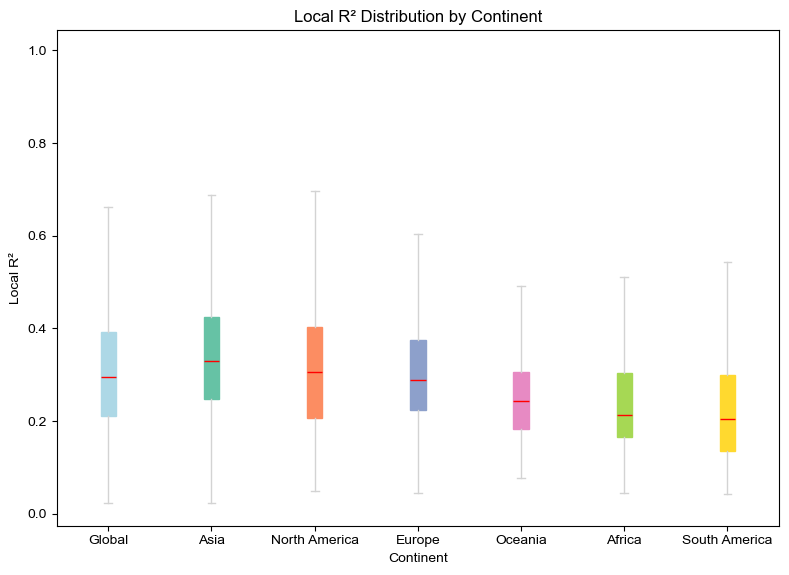

In [328]:
import matplotlib.pyplot as plt
import numpy as np

# 设置默认字体为 Arial
plt.rcParams['font.family'] = 'Arial'

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(8, 6))  # 可以调整图形大小

colors = plt.get_cmap('Set2').colors  # 适合离散分类数据的调色板

# 计算每个 continent 的中位数并进行排序
median_values = {continent: gdf[gdf['continent'] == continent]['local_R2'].median() for continent in gdf['continent'].unique()}
sorted_continents = sorted(median_values, key=median_values.get, reverse=True)

# 添加全体数据（global 数据）的箱线图
global_data = gdf['local_R2']
ax.boxplot(global_data, positions=[0], 
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='lightblue'),  # 移除轮廓
            medianprops=dict(color='red'), 
            whiskerprops=dict(color='lightgray'), 
            capprops=dict(color='lightgray'), 
            flierprops=dict(marker='None'))  # 确保不显示任何异常点

# 为每个 continent 的数据绘制箱线图
for i, continent in enumerate(sorted_continents):
    # 选择当前 continent 的数据
    data = gdf[gdf['continent'] == continent]['local_R2']
    # 绘制箱线图
    ax.boxplot(data, positions=[i + 1], 
                patch_artist=True,
                boxprops=dict(facecolor=colors[i % len(colors)], color=colors[i % len(colors)]),  # 移除轮廓
                medianprops=dict(color='red'), 
                whiskerprops=dict(color='lightgray'), 
                capprops=dict(color='lightgray'), 
                flierprops=dict(marker='None'))  # 确保不显示任何异常点

# 设置图表标题和轴标签
ax.set_title('Local R² Distribution by Continent')
ax.set_xlabel('Continent')
ax.set_ylabel('Local R²')
ax.set_xticks(np.arange(0, len(sorted_continents) + 1))  # 设置 x 轴刻度，包括 global 数据
ax.set_xticklabels(['Global'] + sorted_continents)  # 设置 x 轴标签为 Global 和排序后的大洲名称

plt.suptitle('')  # 移除默认的分组标题

plt.tight_layout()
plt.show()  # 显示图形

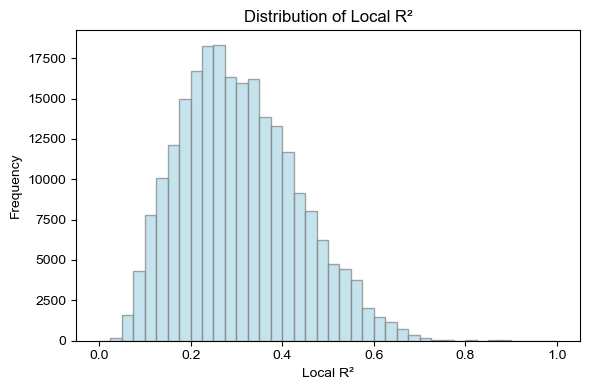

In [266]:
import matplotlib.pyplot as plt
import numpy as np

# 设置默认字体为 Arial
plt.rcParams['font.family'] = 'Arial'

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(6, 4))  # 可以调整图形大小

# 获取所有 local_R2 数据
data = gdf['local_R2']

# 设置 bins，从 0 开始，最大值可以根据数据的实际情况来设定
max_value = np.ceil(data.max() / 0.025) * 0.025  # 向上取整到最近的 0.05
bins = np.arange(0, max_value + 0.025, 0.025)  # 生成 bins 范围

# 绘制直方图
ax.hist(data, bins=bins, color='lightblue', edgecolor='gray', alpha=0.7)

# 设置图表标题和轴标签
ax.set_title('Distribution of Local R²')
ax.set_xlabel('Local R²')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()  # 显示图形

In [256]:
gdf.to_csv("gwr_result_coefs_r2_1102.csv")

In [211]:
# 创建国家与大洲的映射字典
continent_mapping = {
    'Zambia': 'Africa',
    'Namibia': 'Africa',
    'Zimbabwe': 'Africa',
    'Botswana': 'Africa',
    'Kenya': 'Africa',
    'Mozambique': 'Africa',
    'Bulgaria': 'Europe',
    "Côte d'Ivoire": 'Africa',
    'Malawi': 'Africa',
    'Madagascar': 'Africa',
    'Yemen': 'Asia',
    'Cambodia': 'Asia',
    'Rwanda': 'Africa',
    'Tanzania': 'Africa',
    'Togo': 'Africa'
}

# 为缺少 continent 的国家添加 continent 信息
gdf['continent'] = gdf.apply(
    lambda row: continent_mapping.get(row['COUNTRY'], row['continent']),
    axis=1
)

# 查看更新后的 gdf
print(gdf['continent'].unique())

['North America' 'Europe' 'Africa' 'Asia' 'South America' 'Oceania']


In [292]:
gdf0 = gdf[gdf['continent']=='Asia']


/var/folders/d8/sjpsqxx96jx3_z187n5nywf80000gn/T/ipykernel_82771/1999889432.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  # 加载世界地图数据


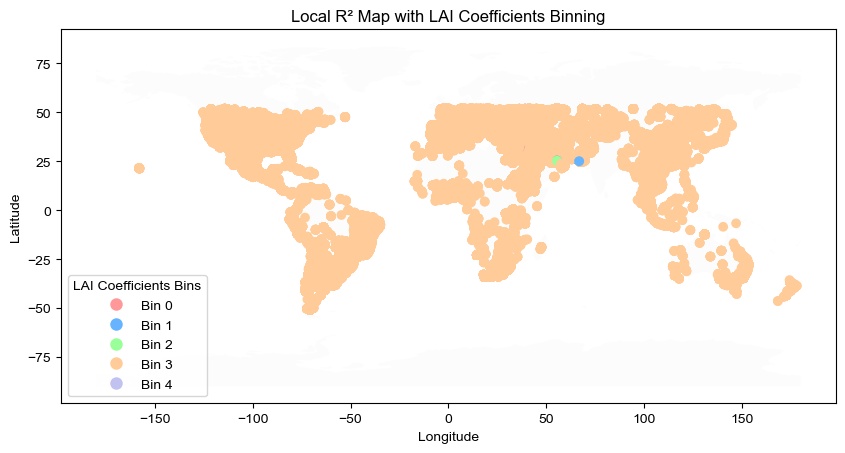

In [310]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取数据，确保gdf是一个GeoDataFrame
# gdf = gpd.read_file('your_data_file.shp')  # 根据需要替换为你的数据文件

# 定义颜色映射
value_to_color = {
    0: '#ff9999',  # Color for bin 0
    1: '#66b3ff',  # Color for bin 1
    2: '#99ff99',  # Color for bin 2
    3: '#ffcc99',  # Color for bin 3
    4: '#c2c2f0'   # Color for bin 4
}

# 将bin值映射到颜色
gdf['color'] = gdf['LAI_coef_binned'].map(value_to_color)

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 10))  # 设定绘图大小

# 绘制世界地图背景
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  # 加载世界地图数据
world.plot(ax=ax, color='lightgray', alpha=0.05)

# 绘制填色的local R²地图
gdf.plot(color=gdf['color'], ax=ax, legend=True)

# 添加图例
legend_labels = ['Bin 0', 'Bin 1', 'Bin 2', 'Bin 3', 'Bin 4']
patches = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                       markerfacecolor=color, markersize=10) 
           for label, color in zip(legend_labels, value_to_color.values())]
ax.legend(handles=patches, title='LAI Coefficients Bins')

# 设置标题和坐标轴
plt.title('Local R² Map with LAI Coefficients Binning')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 显示图形
plt.show()

[3 2 1 0 4]


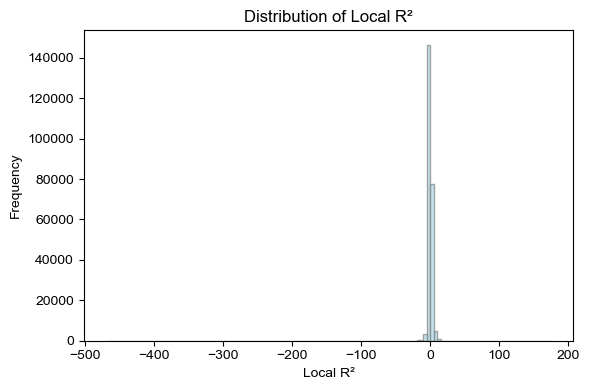

In [286]:
import matplotlib.pyplot as plt
import numpy as np

# 设置默认字体为 Arial
plt.rcParams['font.family'] = 'Arial'

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(6, 4))  # 可以调整图形大小

# 获取所有 local_R2 数据
data = gdf['LAI_coef']

# 设置 bins，从 0 开始，最大值可以根据数据的实际情况来设定
max_value = np.ceil(data.max() / 5) * 5  # 向上取整到最近的 0.05
bins = np.arange(data.min(), max_value + 5, 5)  # 生成 bins 范围

# 绘制直方图
ax.hist(data, bins=bins, color='lightblue', edgecolor='gray', alpha=0.7)

# 设置图表标题和轴标签
ax.set_title('Distribution of LAI')
ax.set_xlabel('Local R²')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()  # 显示图形

In [23]:
len(gdf[(gdf['LAI_coef']>50) | (gdf['LAI_coef']>-50)])
len(gdf[(gdf['LAI_coef']>100) | (gdf['LAI_coef']>-300)])

NameError: name 'data' is not defined

In [278]:
print(gdf['LAI_coef'].min(), gdf['LAI_coef'].max())

-469.6133896580829 171.17110252264933


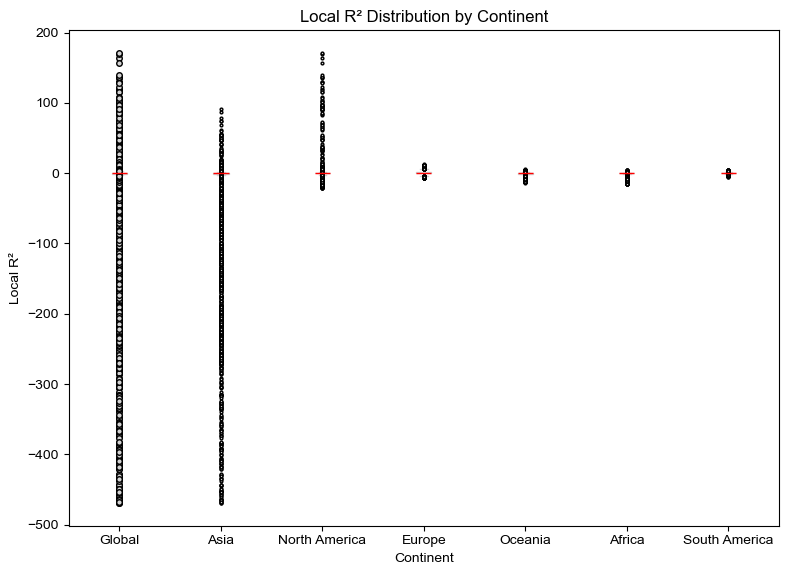

In [288]:
import matplotlib.pyplot as plt
import numpy as np
# 设置默认字体为 Arial
plt.rcParams['font.family'] = 'Arial'

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(8, 6))  # 可以调整图形大小

colors = plt.get_cmap('Set2').colors  # 适合离散分类数据的调色板

# 计算每个 continent 的中位数并进行排序
median_values = {continent: gdf[gdf['continent'] == continent]['local_R2'].median() for continent in gdf['continent'].unique()}
sorted_continents = sorted(median_values, key=median_values.get, reverse=True)

# 添加全体数据（global 数据）的箱线图
global_data = gdf['LAI_coef']
ax.boxplot(global_data, positions=[0], 
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='lightgray'),
            medianprops=dict(color='red'), 
            whiskerprops=dict(color='lightgray'), 
            capprops=dict(color='lightgray'),
            flierprops=dict(marker='o', markerfacecolor='lightgray', markersize=4, linestyle='none'))  # 修改轮廓点的样式

# 为每个 continent 的数据绘制箱线图
for i, continent in enumerate(sorted_continents):
    # 选择当前 continent 的数据
    data = gdf[gdf['continent'] == continent]['LAI_coef']
    # 绘制箱线图
    ax.boxplot(data, positions=[i + 1], 
                patch_artist=True,
                boxprops=dict(facecolor=colors[i % len(colors)], color='lightgray'),
                medianprops=dict(color='red'), 
                whiskerprops=dict(color='lightgray'), 
                capprops=dict(color='lightgray'),
                flierprops=dict(marker='o', markerfacecolor='lightgray', markersize=2, linestyle='none'))  # 修改轮廓点的样式

# 设置图表标题和轴标签
ax.set_title('Local R² Distribution by Continent')
ax.set_xlabel('Continent')
ax.set_ylabel('Local R²')
ax.set_xticks(np.arange(0, len(sorted_continents) + 1))  # 设置 x 轴刻度，包括 global 数据
ax.set_xticklabels(['Global'] + sorted_continents)  # 设置 x 轴标签为 Global 和排序后的大洲名称

plt.suptitle('')  # 移除默认的分组标题

plt.tight_layout()
plt.show()  # 显示图形

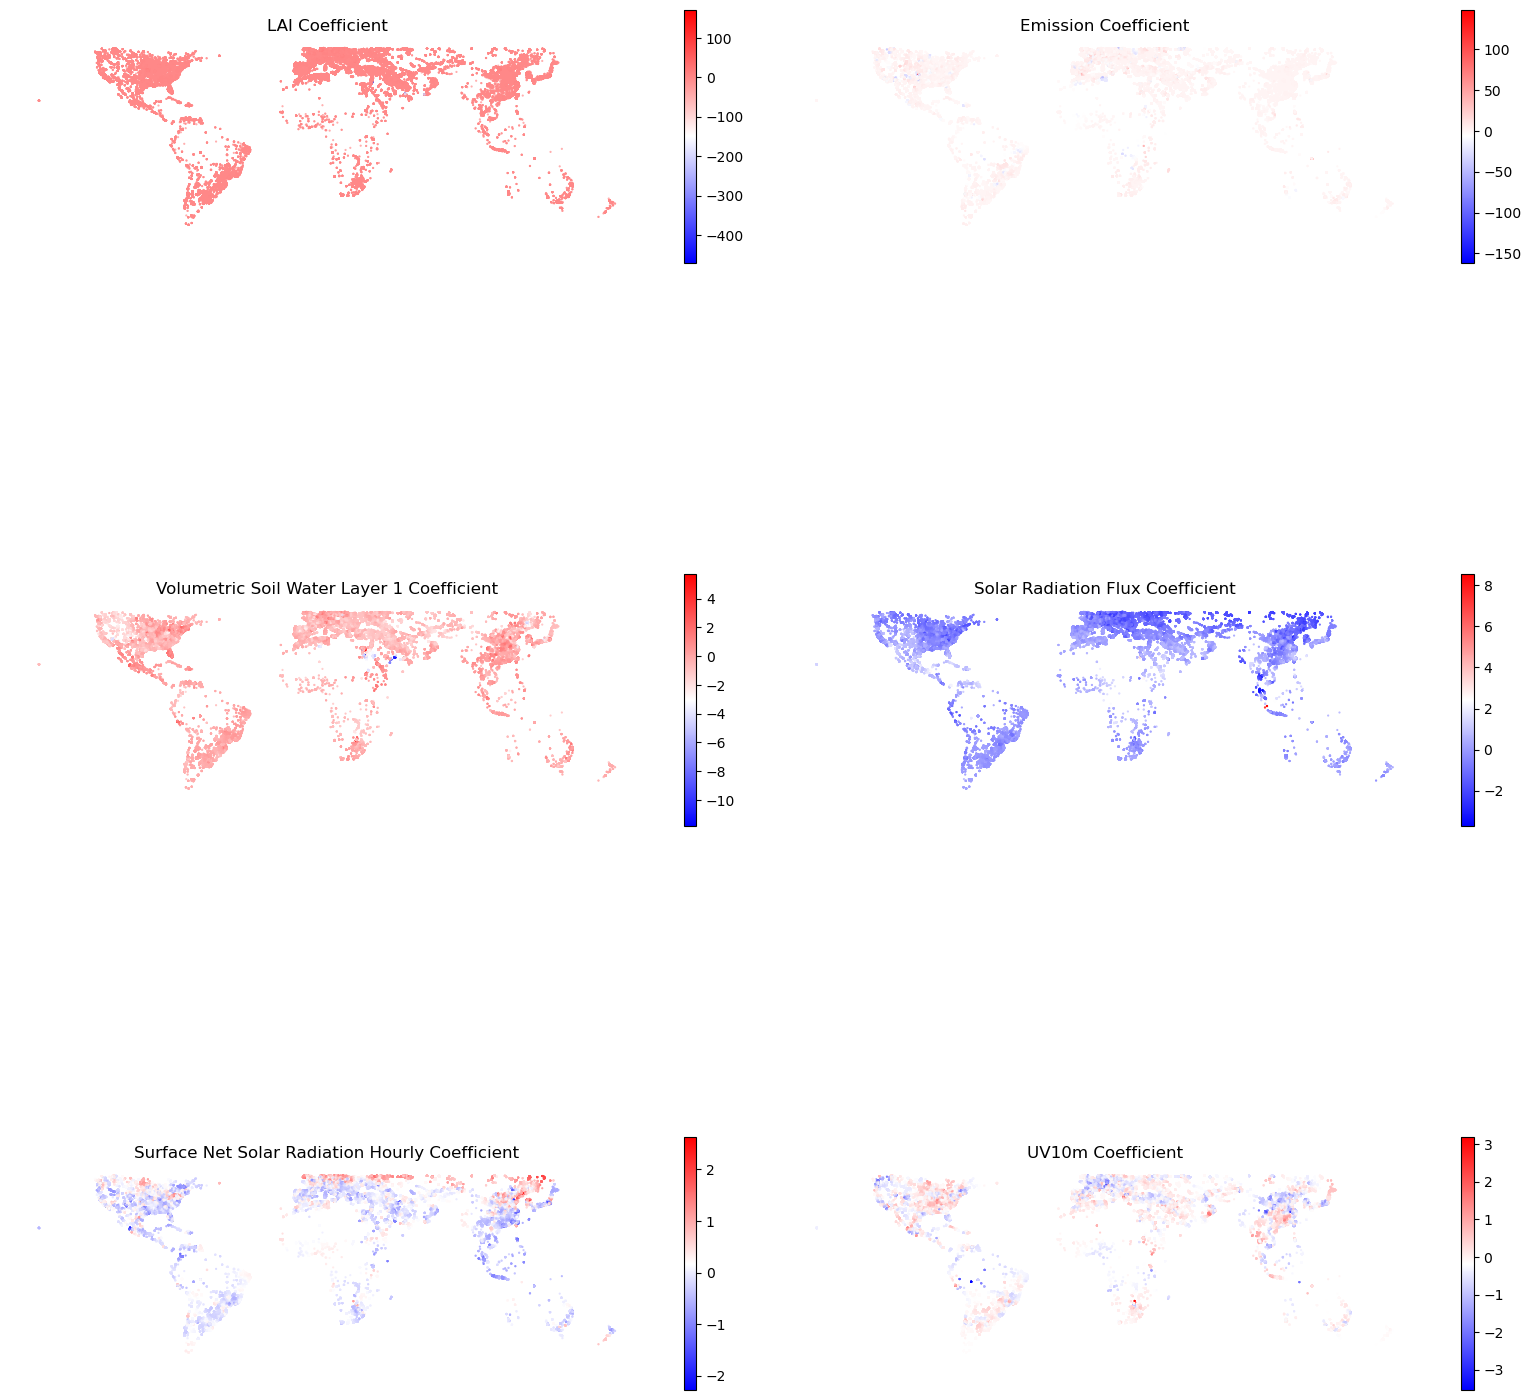

In [162]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 创建 3x2 的子图布局
fig, axes = plt.subplots(3, 2, figsize=(16, 20))

# 定义自定义颜色映射（colormap）
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'], N=256)

# 绘制 LAI 系数地图
gdf.plot(column='LAI_coef', ax=axes[0, 0], legend=True, cmap=cmap,
         vmin=gdf['LAI_coef'].min(), vmax=gdf['LAI_coef'].max(),
         markersize=0.3, alpha=0.7, legend_kwds={'shrink': 0.3})
axes[0, 0].set_title('LAI Coefficient')
axes[0, 0].set_axis_off()

# 绘制 emission 系数地图
gdf.plot(column='emission_coef', ax=axes[0, 1], legend=True, cmap=cmap,
         vmin=gdf['emission_coef'].min(), vmax=gdf['emission_coef'].max(),
         markersize=0.3, alpha=0.7, legend_kwds={'shrink': 0.3})
axes[0, 1].set_title('Emission Coefficient')
axes[0, 1].set_axis_off()

# 绘制 volumetric_soil_water_layer_1 系数地图
gdf.plot(column='volumetric_soil_water_layer_1_coef', ax=axes[1, 0], legend=True, cmap=cmap,
         vmin=gdf['volumetric_soil_water_layer_1_coef'].min(), vmax=gdf['volumetric_soil_water_layer_1_coef'].max(),
         markersize=0.3, alpha=0.7, legend_kwds={'shrink': 0.3})
axes[1, 0].set_title('Volumetric Soil Water Layer 1 Coefficient')
axes[1, 0].set_axis_off()

# 绘制 Solar_Radiation_Flux 系数地图
gdf.plot(column='Solar_Radiation_Flux_coef', ax=axes[1, 1], legend=True, cmap=cmap,
         vmin=gdf['Solar_Radiation_Flux_coef'].min(), vmax=gdf['Solar_Radiation_Flux_coef'].max(),
         markersize=0.3, alpha=0.7, legend_kwds={'shrink': 0.3})
axes[1, 1].set_title('Solar Radiation Flux Coefficient')
axes[1, 1].set_axis_off()

# 绘制 surface_net_solar_radiation_hourly 系数地图
gdf.plot(column='surface_net_solar_radiation_hourly_coef', ax=axes[2, 0], legend=True, cmap=cmap,
         vmin=gdf['surface_net_solar_radiation_hourly_coef'].min(), vmax=gdf['surface_net_solar_radiation_hourly_coef'].max(),
         markersize=0.3, alpha=0.7, legend_kwds={'shrink': 0.3})
axes[2, 0].set_title('Surface Net Solar Radiation Hourly Coefficient')
axes[2, 0].set_axis_off()

# 绘制 uv10m 系数地图
gdf.plot(column='uv10m_coef', ax=axes[2, 1], legend=True, cmap=cmap,
         vmin=gdf['uv10m_coef'].min(), vmax=gdf['uv10m_coef'].max(),
         markersize=0.3, alpha=0.7, legend_kwds={'shrink': 0.3})
axes[2, 1].set_title('UV10m Coefficient')
axes[2, 1].set_axis_off()

plt.tight_layout()
plt.show()

In [167]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import joblib
# 指定模型保存的路径
model_filename = "gwr_model_1101.pkl"

# 读取模型
gwr_results1 = joblib.load(model_filename)

# 将 local R² 值添加到 GeoDataFrame
gdf['local_R1'] = gwr_results1.localR2
gdf

,datetime,longitude,latitude,NE,emission,uv10m,temperature_2m,LAI,volumetric_soil_water_layer_1,surface_net_solar_radiation_hourly,...,Solar_Radiation_Flux,geometry,LAI_coef,emission_coef,volumetric_soil_water_layer_1_coef,Solar_Radiation_Flux_coef,surface_net_solar_radiation_hourly_coef,uv10m_coef,local_R2,local_R1
125982,2022-02-14 14:40:34,-97.287255,41.418327,-3.485008,2756.788180,3.011335,270.270309,0.656250,0.259476,4.308800e+04,...,13989443.0,POINT (-97.28726 41.41833),-3.303943,8.883106,-0.616890,0.317784,0.436381,0.278455,0.351143,0.351143
126602,2022-02-18 11:49:10,13.086457,41.921514,-3.495759,3007.149200,1.457302,285.341492,4.321655,0.378082,1.562850e+06,...,11806849.0,POINT (13.08646 41.92151),0.787411,-7.689021,-1.167377,-0.436996,-0.204234,-0.835089,0.231086,0.231086
80518,2021-04-23 09:26:43,8.518440,49.087270,-2.884603,10027.520200,2.105589,283.687247,3.669604,0.326224,1.900017e+06,...,24513096.0,POINT (8.51844 49.08727),1.341813,-1.823941,-0.511928,-1.401903,0.159770,-0.336591,0.226036,0.226036
88157,2021-06-14 06:05:20,31.139454,30.204014,-1.848170,6103.343800,2.165091,296.818375,4.430420,0.087448,1.362722e+06,...,28738852.0,POINT (31.13945 30.20401),-0.091967,0.027592,-2.249846,0.426685,-0.285075,0.008199,0.231182,0.231182
8417,2019-10-17 23:06:44,-115.292340,36.138702,-0.303115,30556.552091,7.309271,299.556428,0.515625,0.017260,1.276919e+06,...,17489522.0,POINT (-115.29234 36.13870),-0.004978,0.470921,-3.692826,0.077087,0.662945,-0.358939,0.374770,0.374770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232311,2023-09-22 16:26:30,2.037916,41.572826,0.246888,38457.950000,1.911244,295.130051,6.262085,0.190369,1.170254e+06,...,18013938.0,POINT (2.03792 41.57283),-0.029304,-1.719815,-0.961370,0.449987,-0.117751,-0.491841,0.264624,0.264624
5274,2019-09-22 17:24:06,-58.603324,-34.513211,0.851535,83685.860375,3.337622,289.974958,4.743564,0.330905,2.636989e+06,...,22523350.0,POINT (-58.60332 -34.51321),0.666787,-0.226654,-0.391587,-0.340894,0.015225,-0.180339,0.165346,0.165346
211711,2023-06-17 04:56:39,135.210232,34.867355,0.504560,11811.648600,2.283553,299.145575,6.018311,0.460165,2.871397e+06,...,28528772.0,POINT (135.21023 34.86735),0.341496,0.930380,-0.376079,0.822745,-0.525775,-0.299359,0.235296,0.235296
232817,2023-09-25 04:30:39,115.251920,-8.642579,0.178890,23720.572000,4.322248,299.665848,7.636230,0.199631,2.981113e+06,...,23589440.0,POINT (115.25192 -8.64258),0.024606,0.079733,0.257042,-0.246874,-0.422551,-0.165891,0.220244,0.220244


In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 过滤掉南极洲
world = world[world.name != 'Antarctica']  # 移除南极洲

# 创建图形
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# 绘制灰色世界地图
world.boundary.plot(ax=ax, linewidth=0.2, color='gray')  # 添加世界地图边界
world.plot(ax=ax, color='lightgray', alpha=0.05)  # 添加世界地图填充

# 绘制 local R² 地图
gdf.plot(column='local_R2', ax=ax, 
         legend=True, cmap='jet', 
         markersize=0.25, 
         #alpha=0.8,
         legend_kwds={'shrink': 0.3})

ax.set_title('Local R² in GWR model')

# 设置经纬度网格
ax.grid(True, which='both', linestyle='--', linewidth=0.2, alpha=0.8, color='gray')
ax.set_xticks(range(-160, 181, 50))  # 设置经度刻度
ax.set_yticks(range(-60, 75, 30))    # 设置纬度刻度

plt.tight_layout()
plt.show()

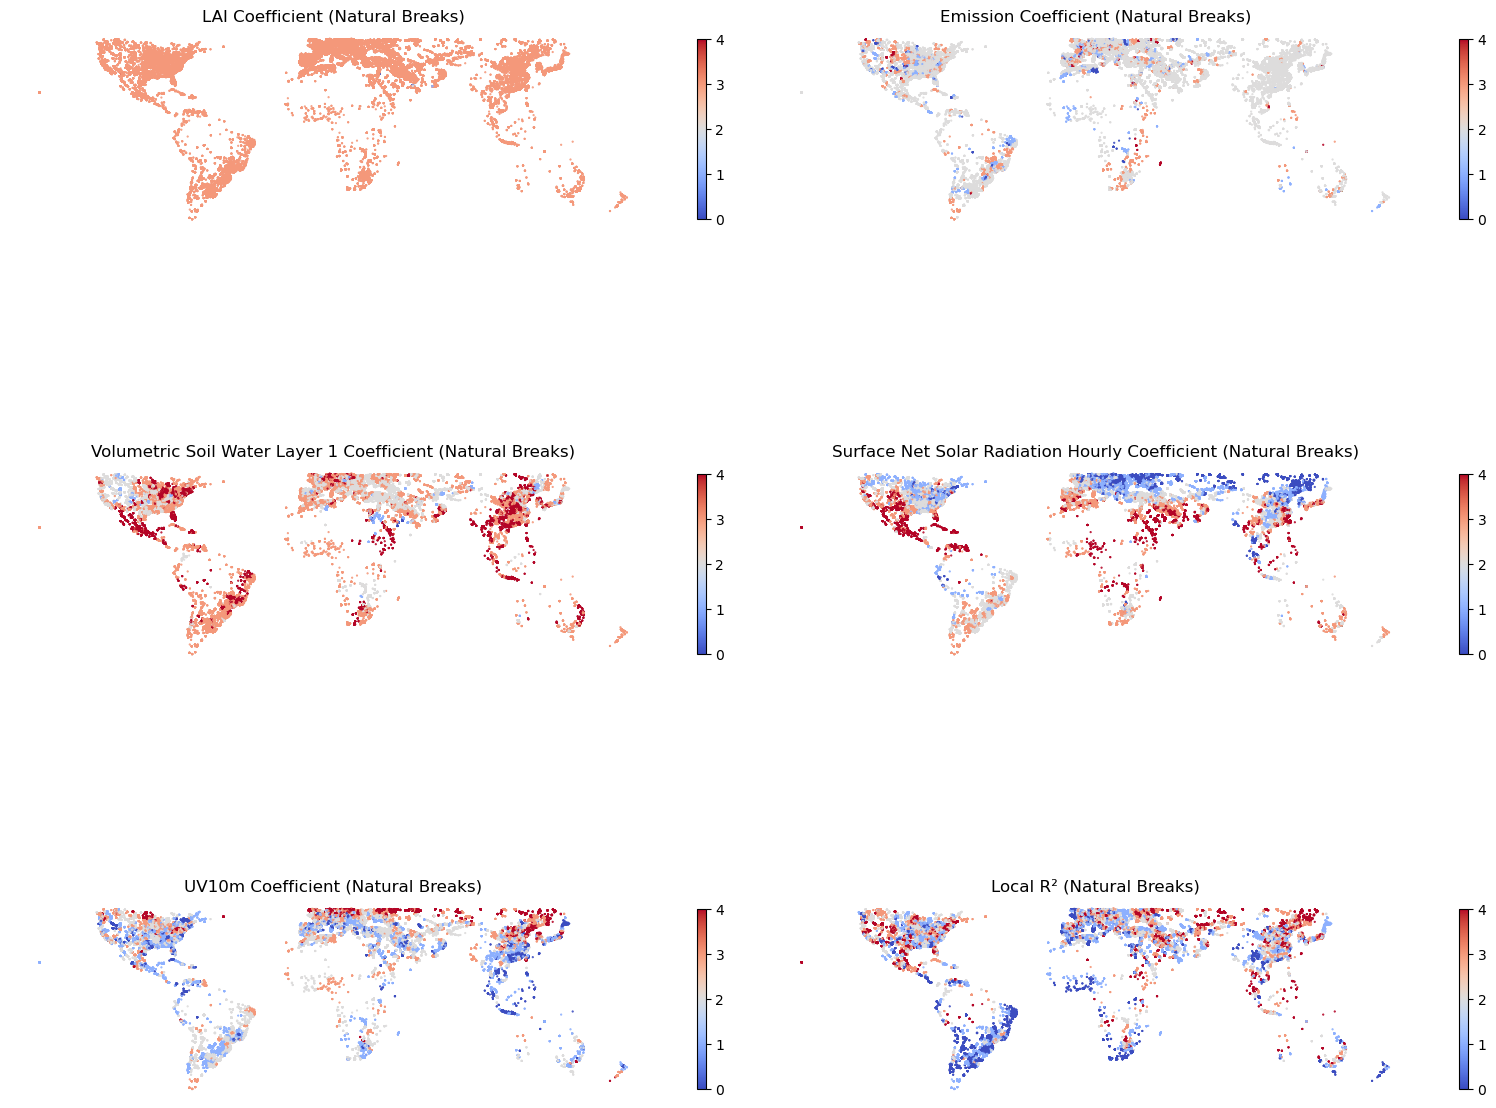

In [27]:
#no nb methods
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mgwr.gwr import GWR
from sklearn.preprocessing import StandardScaler
from mapclassify import NaturalBreaks

# 提取系数
params = gwr_results.params

# 将系数添加到 GeoDataFrame
gdf['LAI_coef'] = params[:, 1]  # LAI 的系数
gdf['emission_coef'] = params[:, 2]  # emission 的系数
gdf['volumetric_soil_water_layer_1_coef'] = params[:, 3]  # volumetric_soil_water_layer_1 的系数
gdf['surface_net_solar_radiation_hourly_coef'] = params[:, 4]  # surface_net_solar_radiation_hourly 的系数
gdf['uv10m_coef'] = params[:, 5]  # uv10m 的系数

# 添加局部 R² 值到 GeoDataFrame
gdf['local_R2'] = gwr_results.localR2  # 提取局部 R² 值

# 创建自然断点分类器
nb_LAI = NaturalBreaks(gdf['LAI_coef'], k=5)
nb_emission = NaturalBreaks(gdf['emission_coef'], k=5)
nb_volumetric_soil_water_layer_1 = NaturalBreaks(gdf['volumetric_soil_water_layer_1_coef'], k=5)
nb_surface_net_solar_radiation_hourly = NaturalBreaks(gdf['surface_net_solar_radiation_hourly_coef'], k=5)
nb_uv10m = NaturalBreaks(gdf['uv10m_coef'], k=5)
nb_local_R2 = NaturalBreaks(gdf['local_R2'], k=5)

# 将分类结果添加到 GeoDataFrame
gdf['LAI_class'] = nb_LAI.yb
gdf['emission_class'] = nb_emission.yb
gdf['volumetric_soil_water_layer_1_class'] = nb_volumetric_soil_water_layer_1.yb
gdf['surface_net_solar_radiation_hourly_class'] = nb_surface_net_solar_radiation_hourly.yb
gdf['uv10m_class'] = nb_uv10m.yb
gdf['local_R2_class'] = nb_local_R2.yb

# 绘制不同特征影响的地图
fig, axes = plt.subplots(3, 2, figsize=(16, 15))

# LAI 系数地图
gdf.plot(column='LAI_class', ax=axes[0, 0], legend=True, cmap='coolwarm', markersize=0.3,
         legend_kwds={'shrink': 0.3})
axes[0, 0].set_title('LAI Coefficient (Natural Breaks)')
axes[0, 0].set_axis_off()

# emission 系数地图
gdf.plot(column='emission_class', ax=axes[0, 1], legend=True, cmap='coolwarm', markersize=0.3,
         legend_kwds={'shrink': 0.3})
axes[0, 1].set_title('Emission Coefficient (Natural Breaks)')
axes[0, 1].set_axis_off()

# volumetric_soil_water_layer_1 系数地图
gdf.plot(column='volumetric_soil_water_layer_1_class', ax=axes[1, 0], legend=True, cmap='coolwarm', markersize=0.3,
         legend_kwds={'shrink': 0.3})
axes[1, 0].set_title('Volumetric Soil Water Layer 1 Coefficient (Natural Breaks)')
axes[1, 0].set_axis_off()

# surface_net_solar_radiation_hourly 系数地图
gdf.plot(column='surface_net_solar_radiation_hourly_class', ax=axes[1, 1], legend=True, cmap='coolwarm', markersize=0.3,
         legend_kwds={'shrink': 0.3})
axes[1, 1].set_title('Surface Net Solar Radiation Hourly Coefficient (Natural Breaks)')
axes[1, 1].set_axis_off()

# uv10m 系数地图
gdf.plot(column='uv10m_class', ax=axes[2, 0], legend=True, cmap='coolwarm', markersize=0.3,
         legend_kwds={'shrink': 0.3})
axes[2, 0].set_title('UV10m Coefficient (Natural Breaks)')
axes[2, 0].set_axis_off()

# local R² 值地图
gdf.plot(column='local_R2_class', ax=axes[2, 1], legend=True, 
         cmap='coolwarm', markersize=0.3,
         legend_kwds={'shrink': 0.3})
axes[2, 1].set_title('Local R² (Natural Breaks)')
axes[2, 1].set_axis_off()

plt.tight_layout()
plt.show()


In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# 将 local R² 值添加到 GeoDataFrame
gdf['local_R2'] = gwr_results.localR2

# 检查 local_R2 的数据类型并转换为数值类型（处理任何非数值）
gdf['local_R2'] = pd.to_numeric(gdf['local_R2'], errors='coerce')

# 选择 0.1 度或 1 度分辨率
bin_size = 0.1  # 或更改为 1，用于 1° 分辨率

# 创建经纬度的网格化列
gdf['lat_bin'] = (gdf.geometry.y // bin_size) * bin_size
gdf['lon_bin'] = (gdf.geometry.x // bin_size) * bin_size

# 处理缺失值（可以选择填充或删除）
gdf1 = gdf.dropna(subset=['local_R2'])  # 删除包含 local_R2 的缺失值的行
# gdf['local_R2'].fillna(0, inplace=True)  # 或者选择用 0 填充

# 按照 bin_size 进行分组并计算 local_R2 的平均值
gdf_aggregated = gdf1.dissolve(by=['lat_bin', 'lon_bin'], aggfunc='mean')

# 创建表示网格中心的几何图形
gdf_aggregated['geometry'] = gpd1.points_from_xy(gdf_aggregated['lon_bin'] + bin_size / 2,
                                                gdf_aggregated['lat_bin'] + bin_size / 2)

# 设置颜色映射
cmap = 'coolwarm'
norm_local_R2 = Normalize(vmin=gdf_aggregated['local_R2'].min(), vmax=gdf_aggregated['local_R2'].max())

# 创建并绘制聚合后的 local R² 地图
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_aggregated.plot(column='local_R2', ax=ax, legend=True, cmap=cmap, norm=norm_local_R2, markersize=0.3,
                    legend_kwds={'shrink': 0.5})
ax.set_title(f'Aggregated Local R² ({bin_size}° Resolution)')
ax.set_axis_off()

plt.tight_layout()
plt.show()


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
#1009 up

In [9]:
#1s aggregation
from sklearn.preprocessing import StandardScaler
import mgwr.sel_bw as sel_bw

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# 随机抽样50%数据
gdf = gdf.sample(frac=1, random_state=1)
print(len(gdf))

# 提取经纬度作为坐标矩阵
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# 特征矩阵 (X) 和目标变量 (y)
# 使用 float32 来减少内存占用
X = gdf[[#'temperature_2m', 
        'LAI', 
        'emission',  
        'volumetric_soil_water_layer_1', 
        'surface_net_solar_radiation_hourly',
        'uv10m']].values.astype(np.float32)
print('LAI', 
        'emission',  
        'volumetric_soil_water_layer_1', 
        'surface_net_solar_radiation_hourly',
        'uv10m')

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = gdf['NE'].values.astype(np.float32).reshape(-1, 1)

# 将数据分为训练集和测试集 (80% 训练, 20% 测试)
coords_train, coords_test, X_train, X_test, y_train, y_test = train_test_split(
    coords, X, y, test_size=0.2, random_state=42
)


# 选择训练集的带宽 (bw)
bw = 230 #Sel_BW(coords_train, y_train, X_train).search()
print("选定的带宽:", bw)

# 创建并在训练集上拟合 GWR 模型
gwr_model = GWR(coords_train, y_train, X_train, bw=bw, fixed=False, kernel='bisquare')
gwr_results = gwr_model.fit()

# 输出训练集结果
print("训练集 R²:", gwr_results.D2)

# 训练集的 AICc
print("训练集 AICc:", gwr_results.aicc)

# 在测试集上预测
gwr_pred = gwr_model.predict(coords_test, X_test)

# 计算测试集的 R²
y_test_mean = np.mean(y_test)
ss_total = np.sum((y_test - y_test_mean)**2)
ss_residual = np.sum((y_test - gwr_pred.predictions)**2)
r_squared_test = 1 - (ss_residual / ss_total)
print("测试集 R²:", r_squared_test)

# 计算测试集的 RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, gwr_pred.predictions))
print("测试集 RMSE:", rmse_test)

230483
LAI emission volumetric_soil_water_layer_1 surface_net_solar_radiation_hourly uv10m
选定的带宽: 230
训练集 R²: 0.42312709696210404
训练集 AICc: 746532.4392231159
测试集 R²: 0.3406601205954737
测试集 RMSE: 1.8265430350864333


70302
5 features


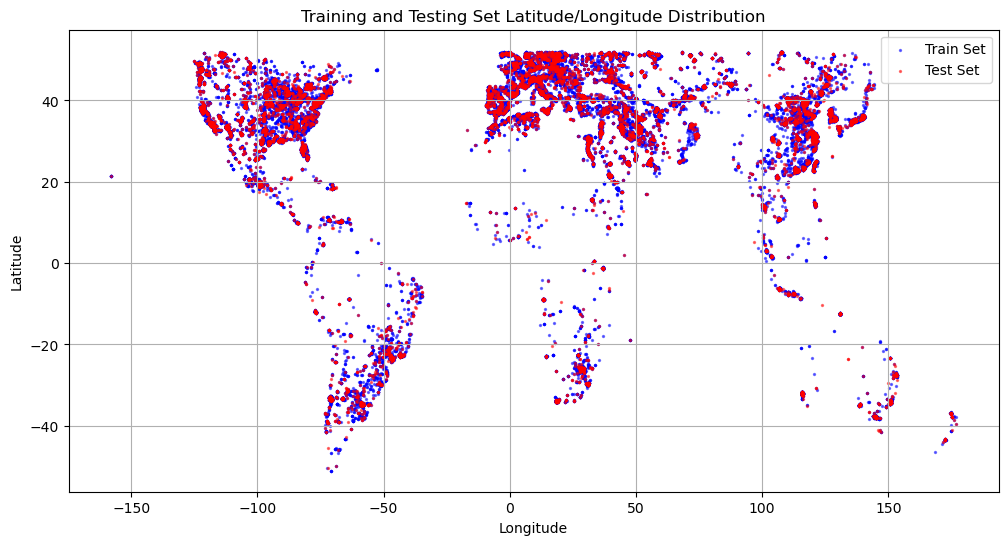

CV选定的带宽: 215.0
训练集 R²: 0.40578567474732874
训练集 AICc: 229506.95863233195
测试集 R²: 0.30418337979262766
测试集 RMSE: 1.8667348339238696


In [16]:
#1s aggregation
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 创建 GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# 随机抽样 30% 数据
gdf = gdf.sample(frac=0.3, random_state=1)
print(len(gdf))

# 提取经纬度作为坐标矩阵
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# 特征矩阵 (X) 和目标变量 (y)
X = gdf[['LAI', 'emission', 'volumetric_soil_water_layer_1', 
          'surface_net_solar_radiation_hourly', 'uv10m']].values.astype(np.float32)
print("5 features")

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = gdf['NE'].values.astype(np.float32).reshape(-1, 1)

# 将数据分为训练集和测试集 (80% 训练, 20% 测试)
coords_train, coords_test, X_train, X_test, y_train, y_test = train_test_split(
    coords, X, y, test_size=0.2, random_state=42
)

# 创建 GeoDataFrame
gdf_train = gdf.iloc[train_test_split(np.arange(len(gdf)), test_size=0.2, random_state=42)[0]]
gdf_test = gdf.iloc[train_test_split(np.arange(len(gdf)), test_size=0.2, random_state=42)[1]]

# 绘制训练集和测试集的经纬度分布
plt.figure(figsize=(12, 6))
plt.scatter(gdf_train.geometry.x, gdf_train.geometry.y, color='blue', label='Train Set', alpha=0.5, s=2)
plt.scatter(gdf_test.geometry.x, gdf_test.geometry.y, color='red', label='Test Set', alpha=0.5, s=2)
plt.title('Training and Testing Set Latitude/Longitude Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

# 选择训练集的带宽 (bw)
bw = Sel_BW(coords_train, y_train, X_train, fixed=False, spherical=True).search(bw_min=50, bw_max=300, criterion='CV')
print("CV选定的带宽:", bw)

# 创建并在训练集上拟合 GWR 模型
gwr_model = GWR(coords_train, y_train, X_train, bw=bw, fixed=False, kernel='bisquare')
gwr_results = gwr_model.fit()

# 输出训练集结果
print("训练集 R²:", gwr_results.D2)

# 训练集的 AICc
print("训练集 AICc:", gwr_results.aicc)

# 在测试集上预测
gwr_pred = gwr_model.predict(coords_test, X_test)

# 计算测试集的 R²
y_test_mean = np.mean(y_test)
ss_total = np.sum((y_test - y_test_mean)**2)
ss_residual = np.sum((y_test - gwr_pred.predictions)**2)
r_squared_test = 1 - (ss_residual / ss_total)
print("测试集 R²:", r_squared_test)

# 计算测试集的 RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, gwr_pred.predictions))
print("测试集 RMSE:", rmse_test)

In [17]:
#1s aggregation
from sklearn.preprocessing import StandardScaler
import mgwr.sel_bw as sel_bw

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# 随机抽样50%数据
gdf = gdf.sample(frac=0.3, random_state=1)
print(len(gdf))

# 提取经纬度作为坐标矩阵
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# 特征矩阵 (X) 和目标变量 (y)
# 使用 float32 来减少内存占用
X = gdf[['temperature_2m', 
        'LAI', 
        'emission',  
        'volumetric_soil_water_layer_1', 
        'surface_net_solar_radiation_hourly',
        'uv10m']].values.astype(np.float32)
print('LAI', 
        'emission',  
        'volumetric_soil_water_layer_1', 
        'surface_net_solar_radiation_hourly',
        'uv10m')

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = gdf['NE'].values.astype(np.float32).reshape(-1, 1)

# 将数据分为训练集和测试集 (80% 训练, 20% 测试)
coords_train, coords_test, X_train, X_test, y_train, y_test = train_test_split(
    coords, X, y, test_size=0.2, random_state=42
)


# 选择训练集的带宽 (bw)
bw = Sel_BW(coords_train, y_train, X_train, fixed=False, spherical=True).search(bw_min=50, bw_max=300, criterion='AICc')
print("CV选定的带宽:", bw)

# 创建并在训练集上拟合 GWR 模型
gwr_model = GWR(coords_train, y_train, X_train, bw=bw, fixed=False, kernel='bisquare')
gwr_results = gwr_model.fit()

# 输出训练集结果
print("训练集 R²:", gwr_results.D2)

# 训练集的 AICc
print("训练集 AICc:", gwr_results.aicc)

# 在测试集上预测
gwr_pred = gwr_model.predict(coords_test, X_test)

# 计算测试集的 R²
y_test_mean = np.mean(y_test)
ss_total = np.sum((y_test - y_test_mean)**2)
ss_residual = np.sum((y_test - gwr_pred.predictions)**2)
r_squared_test = 1 - (ss_residual / ss_total)
print("测试集 R²:", r_squared_test)

# 计算测试集的 RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, gwr_pred.predictions))
print("测试集 RMSE:", rmse_test)

70302
LAI emission volumetric_soil_water_layer_1 surface_net_solar_radiation_hourly uv10m
CV选定的带宽: 228.0
训练集 R²: 0.46367856607492686
训练集 AICc: 224697.1871926179
测试集 R²: 0.36038584060590506
测试集 RMSE: 1.7897578143076756


In [18]:
#1s aggregation
from sklearn.preprocessing import StandardScaler
import mgwr.sel_bw as sel_bw

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# 随机抽样50%数据
gdf = gdf.sample(frac=0.3, random_state=1)
print(len(gdf))

# 提取经纬度作为坐标矩阵
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# 特征矩阵 (X) 和目标变量 (y)
# 使用 float32 来减少内存占用
X = gdf[['temperature_2m', 
        'LAI', 
        'emission',  
        'volumetric_soil_water_layer_1', 
        'surface_net_solar_radiation_hourly',
        'uv10m']].values.astype(np.float32)
print('LAI', 
        'emission',  
        'volumetric_soil_water_layer_1', 
        'surface_net_solar_radiation_hourly',
        'uv10m')

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = gdf['NE'].values.astype(np.float32).reshape(-1, 1)

# 将数据分为训练集和测试集 (80% 训练, 20% 测试)
coords_train, coords_test, X_train, X_test, y_train, y_test = train_test_split(
    coords, X, y, test_size=0.2, random_state=42
)


# 选择训练集的带宽 (bw)
bw = Sel_BW(coords_train, y_train, X_train, fixed=False, spherical=False).search(bw_min=50, bw_max=300, criterion='CV')
print("CV选定的带宽:", bw)

# 创建并在训练集上拟合 GWR 模型
gwr_model = GWR(coords_train, y_train, X_train, bw=bw, fixed=False, kernel='bisquare')
gwr_results = gwr_model.fit()

# 输出训练集结果
print("训练集 R²:", gwr_results.D2)

# 训练集的 AICc
print("训练集 AICc:", gwr_results.aicc)

# 在测试集上预测
gwr_pred = gwr_model.predict(coords_test, X_test)

# 计算测试集的 R²
y_test_mean = np.mean(y_test)
ss_total = np.sum((y_test - y_test_mean)**2)
ss_residual = np.sum((y_test - gwr_pred.predictions)**2)
r_squared_test = 1 - (ss_residual / ss_total)
print("测试集 R²:", r_squared_test)

# 计算测试集的 RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, gwr_pred.predictions))
print("测试集 RMSE:", rmse_test)

70302
LAI emission volumetric_soil_water_layer_1 surface_net_solar_radiation_hourly uv10m
CV选定的带宽: 255.0
训练集 R²: 0.45305319651663434
训练集 AICc: 224707.6726227118
测试集 R²: 0.3607956911927547
测试集 RMSE: 1.789184303836267


In [19]:
#1s aggregation
from sklearn.preprocessing import StandardScaler
import mgwr.sel_bw as sel_bw

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# 随机抽样50%数据
gdf = gdf.sample(frac=0.3, random_state=1)
print(len(gdf))

# 提取经纬度作为坐标矩阵
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# 特征矩阵 (X) 和目标变量 (y)
# 使用 float32 来减少内存占用
X = gdf[['temperature_2m', 
        'LAI', 
        'emission',  
        'volumetric_soil_water_layer_1', 
        'surface_net_solar_radiation_hourly',
        'uv10m']].values.astype(np.float32)
print('LAI', 
        'emission',  
        'volumetric_soil_water_layer_1', 
        'surface_net_solar_radiation_hourly',
        'uv10m')

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = gdf['NE'].values.astype(np.float32).reshape(-1, 1)

# 将数据分为训练集和测试集 (80% 训练, 20% 测试)
coords_train, coords_test, X_train, X_test, y_train, y_test = train_test_split(
    coords, X, y, test_size=0.2, random_state=42
)


# 选择训练集的带宽 (bw)
bw = Sel_BW(coords_train, y_train, X_train, fixed=False, spherical=True).search(bw_min=50, bw_max=300, criterion='BIC')
print("CV选定的带宽:", bw)

# 创建并在训练集上拟合 GWR 模型
gwr_model = GWR(coords_train, y_train, X_train, bw=bw, fixed=False, kernel='bisquare')
gwr_results = gwr_model.fit()

# 输出训练集结果
print("训练集 R²:", gwr_results.D2)

# 训练集的 AICc
print("训练集 AICc:", gwr_results.aicc)

# 在测试集上预测
gwr_pred = gwr_model.predict(coords_test, X_test)

# 计算测试集的 R²
y_test_mean = np.mean(y_test)
ss_total = np.sum((y_test - y_test_mean)**2)
ss_residual = np.sum((y_test - gwr_pred.predictions)**2)
r_squared_test = 1 - (ss_residual / ss_total)
print("测试集 R²:", r_squared_test)

# 计算测试集的 RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, gwr_pred.predictions))
print("测试集 RMSE:", rmse_test)

70302
LAI emission volumetric_soil_water_layer_1 surface_net_solar_radiation_hourly uv10m
CV选定的带宽: 299.0
训练集 R²: 0.43905886634489577
训练集 AICc: 224746.47316114206
测试集 R²: 0.36077287625067034
测试集 RMSE: 1.789216233980877


In [9]:
#monthly
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_squared_error
import numpy as np

# 确保 'month' 列是整数或字符串类型，表示月份
# 假设 df 已经包含 'month' 列，并且 'month' 列的值在 1 到 12 之间

# 创建 GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# 按 'month' 列分组
monthly_groups = gdf.groupby('month')

results = []

for month, group in monthly_groups:
    # 随机抽样30%数据
    group = group.sample(frac=1, random_state=1)
    
    print(f'Processing month: {month}, Sampled rows: {len(group)}')

    # 提取经纬度作为坐标矩阵
    coords = np.array(list(zip(group.geometry.x, group.geometry.y)))

    # 特征矩阵 (X) 和目标变量 (y)
    X = group[[ 'LAI', 
                'emission',  
                'volumetric_soil_water_layer_1', 
                'surface_net_solar_radiation_hourly',
                'uv10m']].values.astype(np.float32)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = group['NE'].values.astype(np.float32).reshape(-1, 1)

    # 将数据分为训练集和测试集 (80% 训练, 20% 测试)
    '''coords_train, coords_test, X_train, X_test, y_train, y_test = train_test_split(
        coords, X, y, test_size=0.2, random_state=42
    )'''

    # 选择训练集的带宽 (bw)
    bw = Sel_BW(coords, y, X, fixed=False, spherical=False).search(bw_min=150, bw_max=300, criterion='CV')
    print({month}, "CV选定的带宽:", bw)

    # 创建并在训练集上拟合 GWR 模型
    gwr_model = GWR(coords, y, X, bw=bw, fixed=False, kernel='bisquare')
    gwr_results = gwr_model.fit()

    # 输出训练集结果
    print("训练集 R²:", gwr_results.D2)
    print("训练集 AICc:", gwr_results.aicc)

# 转换为 DataFrame 并输出结果
results_df = pd.DataFrame(results)
print(results_df)


Processing month: 1.0, Sampled rows: 7346
{1.0} CV选定的带宽: 151.0
训练集 R²: 0.6893829967064349
训练集 AICc: 23327.789436197185
Processing month: 2.0, Sampled rows: 16701
{2.0} CV选定的带宽: 151.0
训练集 R²: 0.6799708426030815
训练集 AICc: 53815.003631679356
Processing month: 3.0, Sampled rows: 9838
{3.0} CV选定的带宽: 193.0
训练集 R²: 0.8221751524301484
训练集 AICc: 30218.822220663897
Processing month: 4.0, Sampled rows: 25937
{4.0} CV选定的带宽: 154.0
训练集 R²: 0.7187287668045104
训练集 AICc: 80935.50865011085
Processing month: 5.0, Sampled rows: 10104
{5.0} CV选定的带宽: 151.0
训练集 R²: 0.747916203070172
训练集 AICc: 31795.78947011636
Processing month: 6.0, Sampled rows: 36025
{6.0} CV选定的带宽: 184.0
训练集 R²: 0.63541788021766
训练集 AICc: 131244.09318956843
Processing month: 7.0, Sampled rows: 13586
{7.0} CV选定的带宽: 151.0
训练集 R²: 0.7423518260884414
训练集 AICc: 48122.760326033196
Processing month: 8.0, Sampled rows: 43755
{8.0} CV选定的带宽: 151.0
训练集 R²: 0.5995300127860026
训练集 AICc: 160301.7652062977
Processing month: 9.0, Sampled rows: 14725
{9.0}

In [ ]:
#1002 up

In [10]:
print("Train R2:", results_df['train_R_squared'].mean(), ", Train AICc:", results_df['train_AICc'].mean(), 
      ", Test R2:", results_df['test_R_squared'].mean(), ",Test RMSE:", results_df['test_RMSE'].mean())

Train R2: 0.6509138952574145 , Train AICc: 52541.31509223453 , Test R2: 0.5581617477055053 ,Test RMSE: 1.313655722883374


KeyboardInterrupt: 

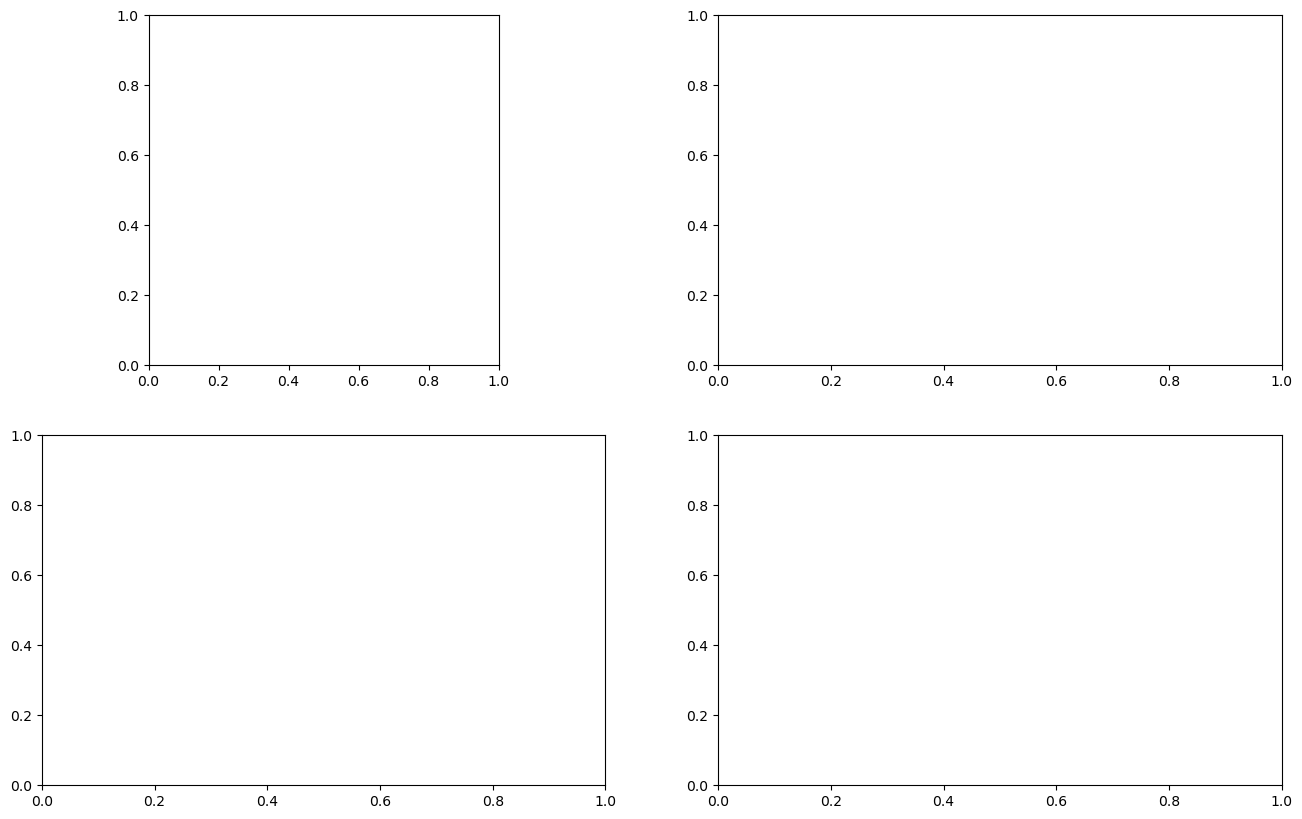

In [16]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mgwr.gwr import GWR
from sklearn.preprocessing import StandardScaler
from mapclassify import NaturalBreaks

# 提取系数
params = gwr_results.params

# 将系数添加到 GeoDataFrame
gdf['temperature_2m_coef'] = params[:, 1]  # LAI 的系数
gdf['LAI_coef'] = params[:, 2]  # LAI 的系数
gdf['emission_coef'] = params[:, 3]  # emission 的系数
gdf['uv10m_coef'] = params[:, 4]  # uv10m 的系数

# 创建自然断点分类器
nb_temperature_2m = NaturalBreaks(gdf['temperature_2m_coef'], k=5)
nb_lai = NaturalBreaks(gdf['LAI_coef'], k=5)
nb_emission = NaturalBreaks(gdf['emission_coef'], k=5)
nb_uv10m = NaturalBreaks(gdf['uv10m_coef'], k=5)

# 将分类结果添加到 GeoDataFrame
gdf['temperature_2m_class'] = nb_temperature_2m.yb
gdf['LAI_class'] = nb_lai.yb
gdf['emission_class'] = nb_emission.yb
gdf['uv10m_class'] = nb_uv10m.yb

# 绘制不同特征影响的地图
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# temperature_2m 系数地图
gdf.plot(column='temperature_2m_class', ax=axes[0, 0], legend=True, cmap='coolwarm', markersize=0.3,
         legend_kwds={'shrink': 0.3})
axes[0, 0].set_title('temperature_2m Coefficient (Natural Breaks)')
axes[0, 0].set_axis_off()

# LAI 系数地图
gdf.plot(column='LAI_class', ax=axes[0, 1], legend=True, cmap='coolwarm', markersize=0.3,
         legend_kwds={'shrink': 0.3})
axes[0,1].set_title('LAI Coefficient (Natural Breaks)')
axes[0,1].set_axis_off()

# emission 系数地图
gdf.plot(column='emission_class', ax=axes[1,0], legend=True, cmap='coolwarm', markersize=0.3,
         legend_kwds={'shrink': 0.3})
axes[1,0].set_title('Emission Coefficient (Natural Breaks)')
axes[1,0].set_axis_off()

# uv10m 系数地图
gdf.plot(column='uv10m_class', ax=axes[1,1], legend=True, cmap='coolwarm', markersize=0.3,
         legend_kwds={'shrink': 0.3})
axes[1,1].set_title('UV10m Coefficient (Natural Breaks)')
axes[1,1].set_axis_off()

plt.tight_layout()
plt.show()

AttributeError: 'NoneType' object has no attribute 'ax'

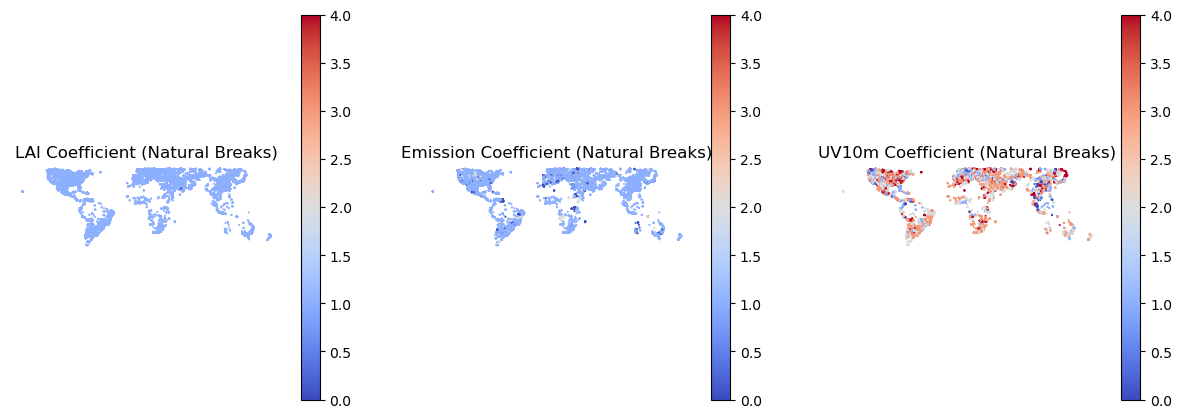

In [24]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mgwr.gwr import GWR
from sklearn.preprocessing import StandardScaler
from mapclassify import NaturalBreaks

# 提取系数
params = gwr_results.params

# 将系数添加到 GeoDataFrame
gdf['LAI_coef'] = params[:, 1]  # LAI 的系数
gdf['emission_coef'] = params[:, 2]  # emission 的系数
gdf['uv10m_coef'] = params[:, 3]  # uv10m 的系数

# 创建自然断点分类器
nb_lai = NaturalBreaks(gdf['LAI_coef'], k=5)
nb_emission = NaturalBreaks(gdf['emission_coef'], k=5)
nb_uv10m = NaturalBreaks(gdf['uv10m_coef'], k=5)

# 将分类结果添加到 GeoDataFrame
gdf['LAI_class'] = nb_lai.yb
gdf['emission_class'] = nb_emission.yb
gdf['uv10m_class'] = nb_uv10m.yb

# 绘制不同特征影响的地图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# LAI 系数地图
laimap = gdf.plot(column='LAI_class', ax=axes[0], legend=True, cmap='coolwarm', markersize=0.3)
axes[0].set_title('LAI Coefficient (Natural Breaks)')
axes[0].set_axis_off()

# emission 系数地图
emissionmap = gdf.plot(column='emission_class', ax=axes[1], legend=True, cmap='coolwarm', markersize=0.3)
axes[1].set_title('Emission Coefficient (Natural Breaks)')
axes[1].set_axis_off()

# uv10m 系数地图
uv10mmap = gdf.plot(column='uv10m_class', ax=axes[2], legend=True, cmap='coolwarm', markersize=0.3)
axes[2].set_title('UV10m Coefficient (Natural Breaks)')
axes[2].set_axis_off()

# 调整 colorbar
for ax in axes:
    # 获取当前图的 colorbar
    cbar = ax.get_legend()
    if cbar is not None:
        # 设置 colorbar 的宽度和位置
        cbar.ax.set_aspect(10)  # 调整宽度
        cbar.ax.tick_params(labelsize=8)  # 调整刻度字体大小

plt.tight_layout()
plt.show()

In [ ]:
df1=df[df['year']==2022]

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# 随机抽样50%数据
gdf = gdf.sample(frac=0.05, random_state=1)

# 提取经纬度作为坐标矩阵
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# 特征矩阵 (X) 和目标变量 (y)
# 使用 float32 来减少内存占用
X = gdf[['temperature_2m', 
         'LAI', #'volumetric_soil_water_layer_1',
         'emission', #'surface_net_solar_radiation_hourly', 
         'uv10m']].values.astype(np.float32)
y = gdf['NE'].values.astype(np.float32).reshape(-1, 1)

# 选择带宽 (bw)
bw = Sel_BW(coords, y, X).search()

# 创建和拟合GWR模型
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

# 输出结果
print(gwr_results.summary())